# Home Work 2

## Modelos de regressão

### Carregamento do dataset e análise exploratória resumida

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, cross_val_score

In [3]:
file_id = "1v0zyWxYV-VgQIbL6OIzDiJe8i3M_ODW4"
url = f"https://drive.google.com/uc?export=download&id={file_id}"

data = pd.read_csv(url)
data.head()


,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


**processamentos dos dados (categoricos --> numericos )**

In [4]:
data_processado = data.copy()

# transformando manualmente para forçar ordem lógica do classificador
mapa_obesidade = {
    'Insufficient_Weight': 0, 'Normal_Weight': 1,
    'Overweight_Level_I': 2, 'Overweight_Level_II': 3,
    'Obesity_Type_I': 4, 'Obesity_Type_II': 5, 'Obesity_Type_III': 6
}
data_processado['NObeyesdad'] = data_processado['NObeyesdad'].map(mapa_obesidade)

mapa_frequencia = {'no': 0, 'Sometimes': 1, 'Frequently': 2, 'Always': 3}
data_processado['CAEC'] = data_processado['CAEC'].map(mapa_frequencia)
data_processado['CALC'] = data_processado['CALC'].map(mapa_frequencia)

#Variáveis BINÁRIAS
cols_binarias = ['Gender', 'family_history_with_overweight', 'FAVC', 'SMOKE', 'SCC']
le = LabelEncoder()
for col in cols_binarias:
    data_processado[col] = le.fit_transform(data_processado[col])

# --- GRUPO 3: Variáveis NOMINAIS (Sem ordem, mais de 2 categorias) ---
# A única no seu dataset é MTRANS. Vamos usar One-Hot Encoding nela.
data_processado = pd.get_dummies(data_processado, columns=['MTRANS'], drop_first=True, dtype=int)

# --- Verificar Resultado Final ---
display(data_processado.head())

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,NObeyesdad,MTRANS_Bike,MTRANS_Motorbike,MTRANS_Public_Transportation,MTRANS_Walking
0,0,21.0,1.62,64.0,1,0,2.0,3.0,1,0,2.0,0,0.0,1.0,0,1,0,0,1,0
1,0,21.0,1.52,56.0,1,0,3.0,3.0,1,1,3.0,1,3.0,0.0,1,1,0,0,1,0
2,1,23.0,1.80,77.0,1,0,2.0,3.0,1,0,2.0,0,2.0,1.0,2,1,0,0,1,0
3,1,27.0,1.80,87.0,0,0,3.0,3.0,1,0,2.0,0,2.0,0.0,2,2,0,0,0,1
4,1,22.0,1.78,89.8,0,0,2.0,1.0,1,0,2.0,0,0.0,0.0,1,3,0,0,1,0


In [5]:
for col in data_processado.select_dtypes(include=['object', 'category', int]).columns:
    print(f"\nColuna: {col}")
    print(data_processado[col].unique())


Coluna: Gender
[0 1]

Coluna: family_history_with_overweight
[1 0]

Coluna: FAVC
[0 1]

Coluna: CAEC
[1 2 3 0]

Coluna: SMOKE
[0 1]

Coluna: SCC
[0 1]

Coluna: CALC
[0 1 2 3]

Coluna: NObeyesdad
[1 2 3 4 0 5 6]

Coluna: MTRANS_Bike
[0 1]

Coluna: MTRANS_Motorbike
[0 1]

Coluna: MTRANS_Public_Transportation
[1 0]

Coluna: MTRANS_Walking
[0 1]


preditores onde a ordem não importa foi  implementado One-Hot Encoding pelo fato do modelo de treinamento ser puramente matemático (Regressão linear) pode ocorrer do modelo associar preditores com maior valor como maior importancia e ter um erro significante. Por outro lado, para categorias onde a ordem importa (CAEC, NObeyesdad), foi implementado o transformador LabelEncoding pois nesse formato garantimos que o modelo entenda a hierarquia onde ela realmente existe.

---

In [6]:
data.shape

(2111, 17)

**Análise para verificar se existe assimetria entre os preditores**



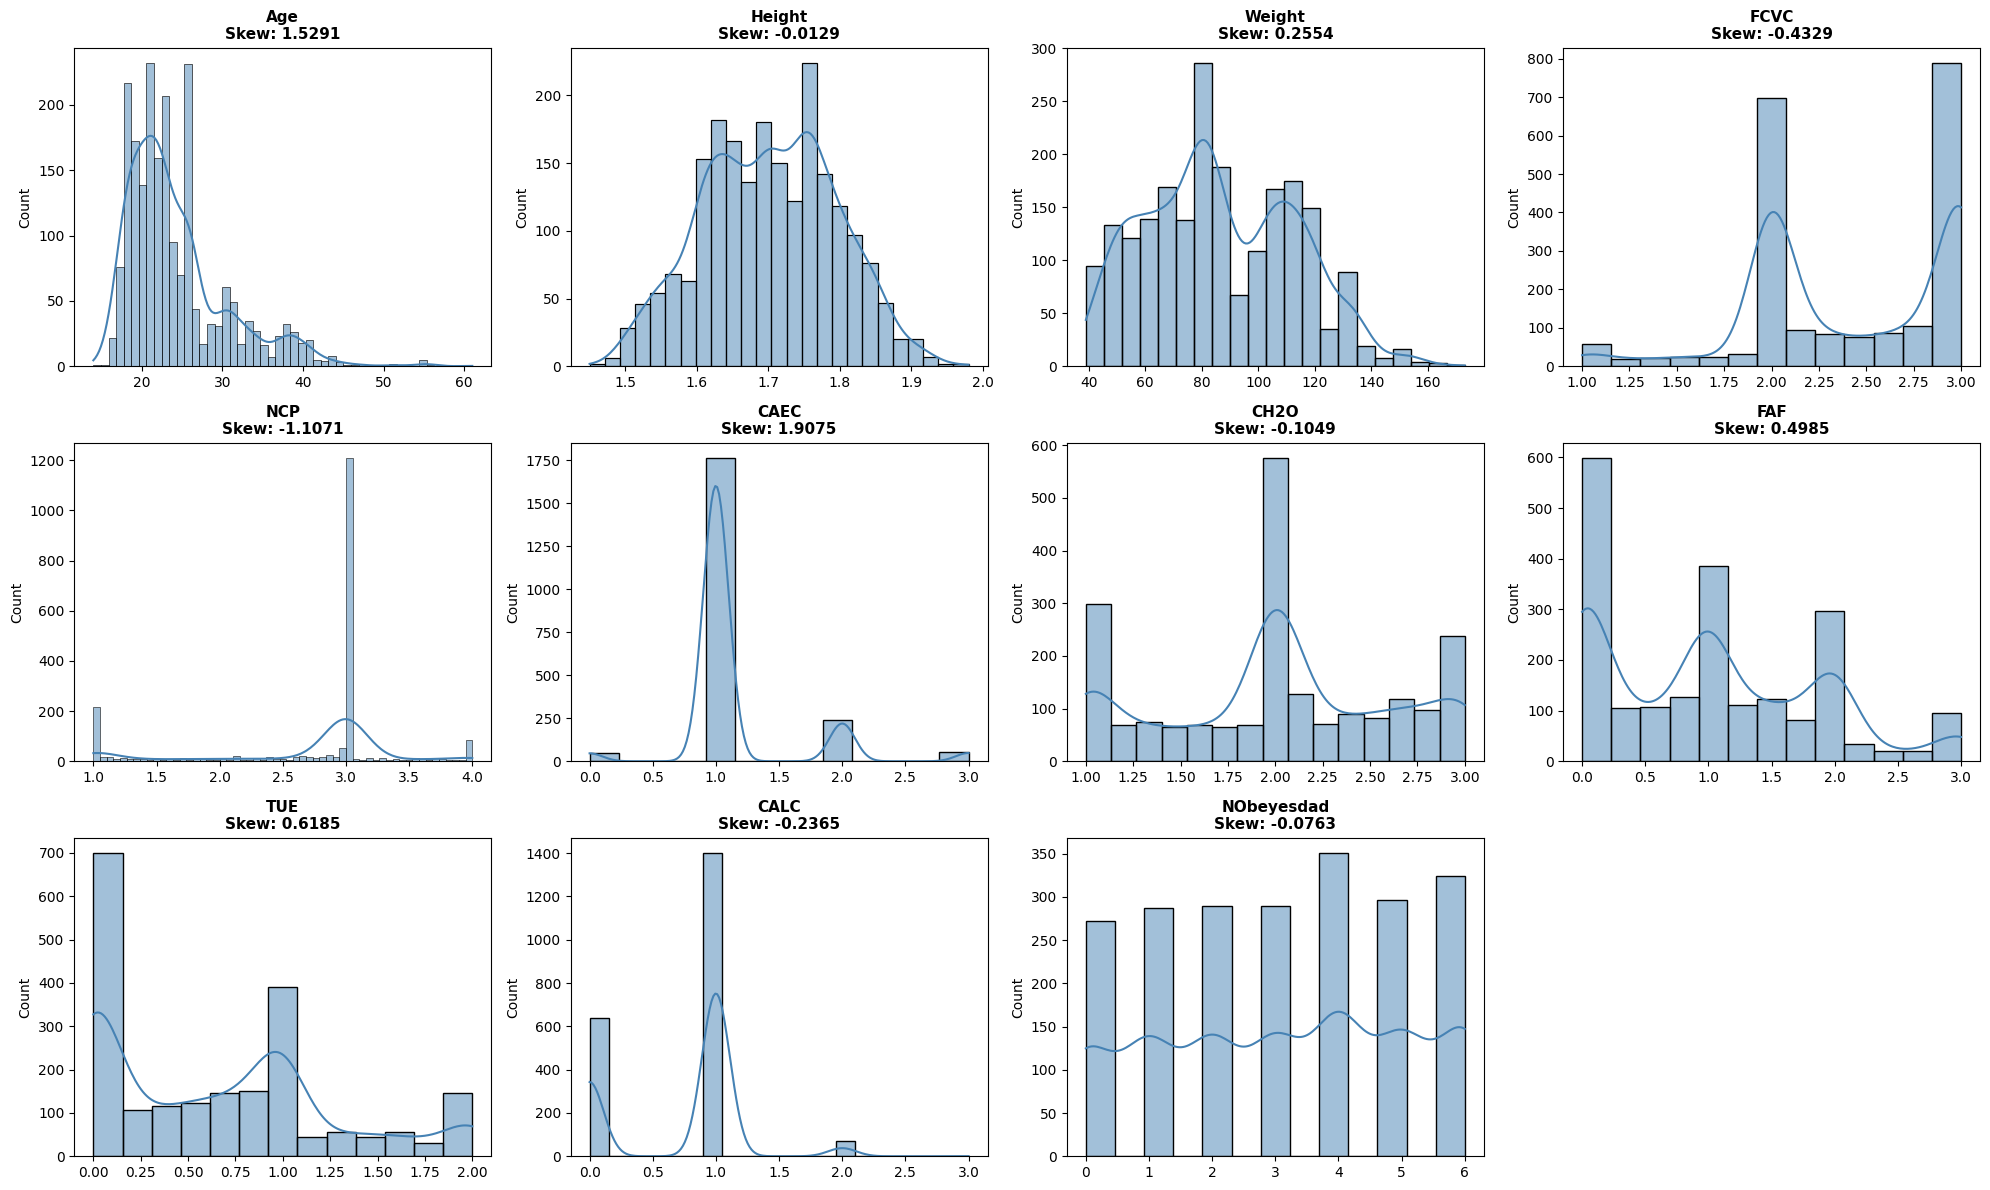

In [7]:
cols_numericas = data_processado.select_dtypes(include=['float64', 'int64']).columns

#pegando apenas as colunas nao binarias para analise de assimetria dos preditores
cols = [col for col in cols_numericas if data_processado[col].nunique() > 2]

num_cols = len(cols)
num_rows = (num_cols + 3) // 4
num_cols_per_row = 4

fig, ax = plt.subplots(num_rows, num_cols_per_row, figsize=(20, 4 * num_rows))
ax = ax.flatten()  # Transforma a matriz em uma lista única para facilitar o loop

#cria os gráficos
for i, col in enumerate(cols):
    #Plota o histograma com a linha de densidade (KDE)
    sns.histplot(data_processado[col], kde=True, ax=ax[i], color='steelblue')

    #Calcula a assimetria
    skew_val = data_processado[col].skew()

    ax[i].set_title(f"{col}\nSkew: {skew_val:.4f}", fontsize=11, fontweight='bold')
    ax[i].set_xlabel("") # Remove label X para limpar o visual

#Remover os subplots vazios, se houver
for j in range(num_cols, len(ax)):
    fig.delaxes(ax[j])

plt.tight_layout()
plt.show()

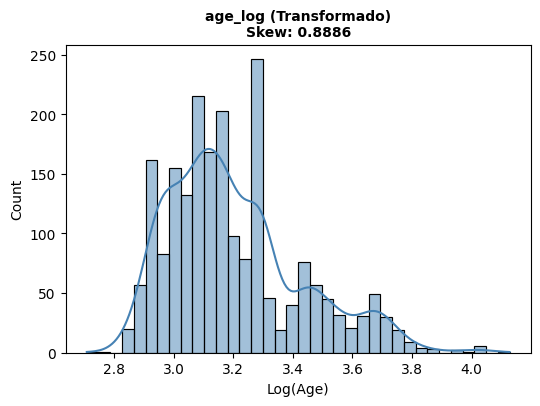

In [8]:
#Aplicando a transformação logarítmica
data_processado['age_log'] = np.log1p(data_processado['Age'])

plt.figure(figsize=(6, 4))
sns.histplot(data_processado['age_log'], kde=True, color='steelblue')

#Calculando a nova assimetria
skew_val = data_processado['age_log'].skew()

plt.title(f"age_log (Transformado)\nSkew: {skew_val:.4f}", fontsize=10, fontweight='bold')
plt.xlabel("Log(Age)")

plt.show()

Analisando os preditores, o gráfico de idade (Age) mostra uma cauda longa para a direita (poucas pessoas mais velhas). aplicar o log para normalizar estes dados é crucial. O Log vai puxa esses valores distantes e deixar a distribuição mais parecida com um sino (Gaussiana), o que ajuda muito a Regressão Linear. Por outro lado, para os outros preditores não é necessário pois ja estão bem distribuidos ou são variáveis ordinais (CAEC), ou seja, não vai transformar os dados em uma curva normal, só muda a distância entre as categorias, o que é irrelevante e pode até ser prejudicial para treinamento do modelo.

---

**Correlação entre Preditores**

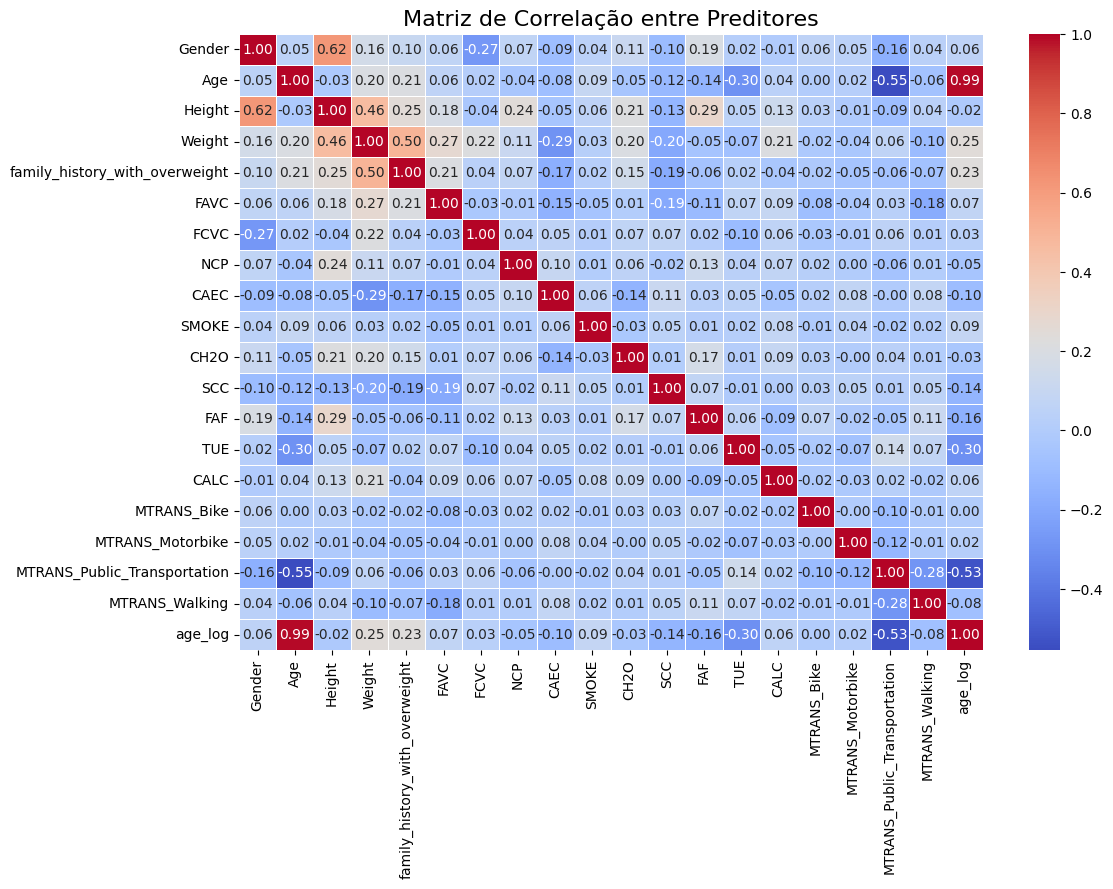

In [9]:
# Excluindo a coluna target para correlação entre preditores
X = data_processado.drop('NObeyesdad', axis=1)

# Calculando a matriz de correlação
correlation_matrix_predictors = X.corr()

# Plotando o heatmap da correlação entre preditores
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix_predictors, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Matriz de Correlação entre Preditores', fontsize=16)
plt.show()

**Correlação entre Preditores e o Target (NObeyesdad)**

/tmp/ipython-input-4267937724.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=correlation_with_target.values, y=correlation_with_target.index, palette='viridis')


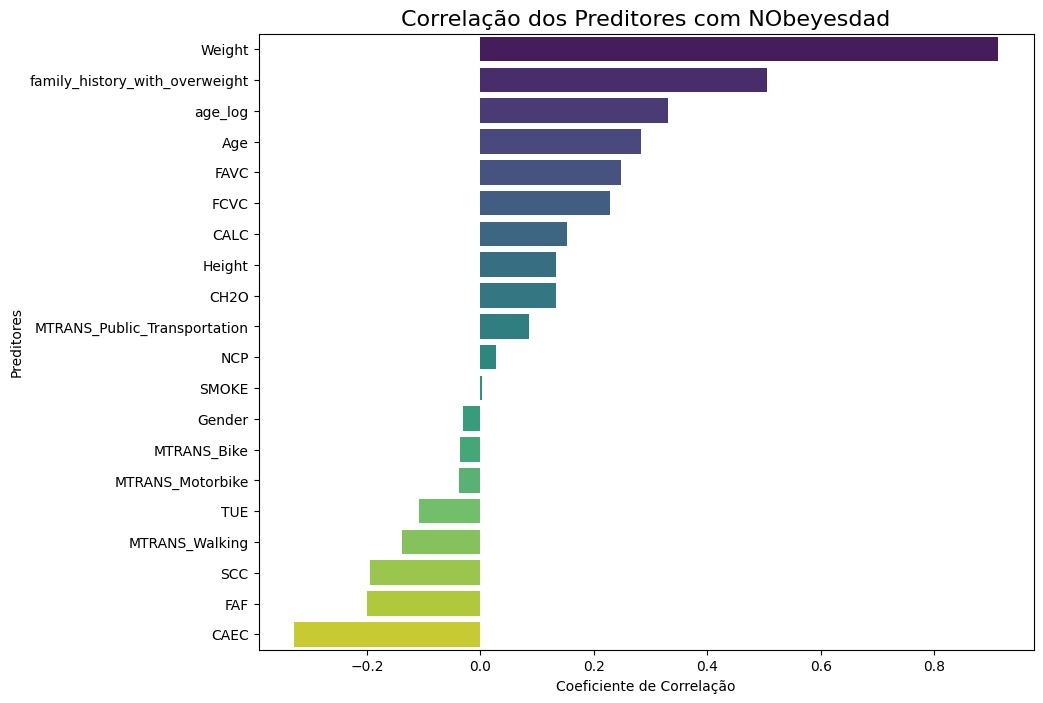

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

# Separando preditores (X) e target (y)
X = data_processado.drop('NObeyesdad', axis=1)
y = data_processado['NObeyesdad']

# Calculando a correlação de cada preditor com o target
correlation_with_target = X.corrwith(y).sort_values(ascending=False)

# Plotando a correlação com o target
plt.figure(figsize=(10, 8))
sns.barplot(x=correlation_with_target.values, y=correlation_with_target.index, palette='viridis')
plt.title('Correlação dos Preditores com NObeyesdad', fontsize=16)
plt.xlabel('Coeficiente de Correlação')
plt.ylabel('Preditores')
plt.show()

**Padronizando e adicionando viés para realizar o treinamento do modelo**

In [11]:
#Padronização (média entre 0 e 1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X) # X vem das etapas anteriores

#Adicionando a coluna de 1's
X_com_bias = np.c_[np.ones((X_scaled.shape[0], 1)), X_scaled]

#(80% Treino, 20% Teste)
X_train, X_test, y_train, y_test = train_test_split(X_com_bias, y, test_size=0.2, random_state=42)

print("--- Formato dos Dados para os Modelos ---")
print(f"X_train shape: {X_train.shape} (linhas, colunas + bias)")
print(f"y_train shape: {y_train.shape}")
print(f"Exemplo de uma linha: \n{X_train[0]}")

--- Formato dos Dados para os Modelos ---
X_train shape: (1688, 21) (linhas, colunas + bias)
y_train shape: (1688,)
Exemplo de uma linha: 
[ 1.         -1.01191369 -0.52212439 -0.76838835 -1.01531759  0.47229133
  0.36234913  1.08834176  0.40415272  3.96921322  6.85399684 -0.01307326
 -0.21827203  1.16382038 -1.08062463  0.52115952 -0.05768012 -0.07237469
  0.57972058 -0.16507758 -0.50410935]


Padronizamos os dados colocando-os para uma média entre 0 e 1 e além disso, foi adicionado uma coluna de 1's para que durante os calculos do modelo de regressão o viés ($ β_0 $) esteja presente. Por fim, separa-se os dados em treino e teste.

---

### Modelo de regressão linear simples (OLS)

Implementaremos a equação da regressão linear (OLS) usando as matrizes dos preditores dos dados de treino e o vetor alvo (y) para encontar  os pesos ($ β$) que minimizam o erro usando a equação normal a seguir:

$$
β = (X^TX)^{-1}X^Ty
$$

In [12]:
X_T = X_train.T
XtX = X_T @ X_train
XtX_inv = np.linalg.pinv(XtX)
Xty = X_T @ y_train
#Cálculo final dos pesos (Betas)
beta_manual = XtX_inv @ Xty

print("Pesos calculados (Primeiros 5):", beta_manual[:5])

Pesos calculados (Primeiros 5): [ 3.11541142  0.02201413 -0.20697874 -0.68426935  2.00223133]


In [13]:
# Importante: fit_intercept=False porque já temos a coluna de 1s em X_train
model_sklearn = LinearRegression(fit_intercept=False)
model_sklearn.fit(X_train, y_train)
beta_sklearn = model_sklearn.coef_
print("Pesos do Sklearn (Primeiros 5):", beta_sklearn[:5])


Pesos do Sklearn (Primeiros 5): [ 3.11541142  0.02201413 -0.20697874 -0.68426935  2.00223133]


In [14]:
#COMPARAÇÃO DE PREDIÇÕES E MÉTRICAS

# Predição Manual: y = X * beta
y_pred_manual = X_test @ beta_manual

# Predição Sklearn: predict()
y_pred_sklearn = model_sklearn.predict(X_test)

# Cálculo das Métricas
rmse_manual = np.sqrt(mean_squared_error(y_test, y_pred_manual))
r2_manual = r2_score(y_test, y_pred_manual)

rmse_sklearn = np.sqrt(mean_squared_error(y_test, y_pred_sklearn))
r2_sklearn = r2_score(y_test, y_pred_sklearn)

print(f'RMSE manual: {rmse_manual}')
print(f'R² manual: {r2_manual}\n')
print(f'RMSE sklearn: {rmse_sklearn}')
print(f'R² sklearn: {r2_sklearn}')


RMSE manual: 0.41883441573757446
R² manual: 0.9558864264945935

RMSE sklearn: 0.41883441573757463
R² sklearn: 0.9558864264945934


os resultados mostram que o modelo implementado manualmente é ligeiramente equivaliente ao modelo pronto utilizando a função da biblioteca sklearn.

---

In [15]:
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)

rmse_scores_manual = []
r2_scores_manual = []

print(f"--- Iniciando Validação Cruzada Manual ({k} Folds) ---")

# O KFold gera os ÍNDICES das linhas para treino e teste
fold = 1
for train_index, test_index in kf.split(X_com_bias):

    #Separando os dados usando os índices do fold atual
    X_train_fold, X_test_fold = X_com_bias[train_index], X_com_bias[test_index]
    y_train_fold, y_test_fold = y[train_index], y[test_index]

    #Treinamento manual
    #beta = (X^T * X)^-1 * X^T * y
    XtX = X_train_fold.T @ X_train_fold
    XtX_inv = np.linalg.pinv(XtX)
    Xty = X_train_fold.T @ y_train_fold
    beta_fold = XtX_inv @ Xty

    #Teste
    y_pred_fold = X_test_fold @ beta_fold

    #Calcular Métricas
    rmse_fold = np.sqrt(mean_squared_error(y_test_fold, y_pred_fold))
    r2_fold = r2_score(y_test_fold, y_pred_fold)

    rmse_scores_manual.append(rmse_fold)
    r2_scores_manual.append(r2_fold)

    print(f"Fold {fold}: RMSE = {rmse_fold:.4f}, R² = {r2_fold:.4f}")
    fold += 1

print("\n--- Comparação das Médias ---")

# Manual
media_rmse_manual = np.mean(rmse_scores_manual)
media_r2_manual = np.mean(r2_scores_manual)

# Sklearn (Nota: sklearn usa 'neg_mean_squared_error', por isso o sinal de menos e o sqrt)
model = LinearRegression(fit_intercept=False) # False porque já temos a coluna de 1s
scores_rmse_sklearn = np.sqrt(-cross_val_score(model, X_com_bias, y, cv=kf, scoring='neg_mean_squared_error'))
scores_r2_sklearn = cross_val_score(model, X_com_bias, y, cv=kf, scoring='r2')

print(f"Média RMSE Manual : {media_rmse_manual:.6f}")
print(f"Média RMSE Sklearn: {scores_rmse_sklearn.mean():.6f}")
print("-" * 30)
print(f"Média R² Manual   : {media_r2_manual:.6f}")
print(f"Média R² Sklearn  : {scores_r2_sklearn.mean():.6f}")

--- Iniciando Validação Cruzada Manual (5 Folds) ---
Fold 1: RMSE = 0.4188, R² = 0.9559
Fold 2: RMSE = 0.4643, R² = 0.9468
Fold 3: RMSE = 0.4084, R² = 0.9563
Fold 4: RMSE = 0.4482, R² = 0.9458
Fold 5: RMSE = 0.4597, R² = 0.9478

--- Comparação das Médias ---
Média RMSE Manual : 0.439891
Média RMSE Sklearn: 0.439891
------------------------------
Média R² Manual   : 0.950503
Média R² Sklearn  : 0.950503


mesmo fazendo validação cruzada pegando diferentes dados de treinos obtivemos uma consistência considerável nos resultados. houve apenas pequenas variações, mostrando que o modelo conseguiu aprender o padrão dos dados, mesmo misturando-os.

---


# Implementação da Regressão Ridge (L2) do Zero

Nesta etapa, implementamos a Regressão Linear com penalidade L2. A função de custo que o Gradiente Descendente tentará minimizar é:
$$
J(\theta) = MSE + \lambda \sum \theta_j^2
$$

Detalhes da Implementação:
- Gradiente: A derivada inclui o termo de regularização $\lambda \theta$.
- Viés (Intercepto): A penalidade não é aplicada ao coeficiente $\theta_0$ (o viés/intercepto), pois queremos restringir a inclinação da reta, não sua posição no espaço.
- Método: Gradiente Descendente Iterativo.

In [16]:
class RidgeRegressionScratch:
    def __init__(self, learning_rate=0.01, n_iterations=1000, lambda_val=1.0):
        self.lr = learning_rate
        self.n_iter = n_iterations
        self.lambda_val = lambda_val
        self.weights = None
        self.cost_history = []

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features) # Inicializa pesos com zero
        self.cost_history = []

        for _ in range(self.n_iter):
            # 1. Predição Linear (Hipótese) -> y = X * w
            y_pred = np.dot(X, self.weights)

            # 2. Cálculo do Erro
            error = y_pred - y

            # 3. Preparar Penalidade (L2)
            # Criamos uma cópia dos pesos para penalizar
            # ZERAMOS o índice 0 para NÃO penalizar o viés (intercepto)
            weights_penalty = self.weights.copy()
            weights_penalty[0] = 0

            # 4. Cálculo do Gradiente
            # Gradiente = (1/m) * X.T * erro + lambda * pesos
            gradient = (1/n_samples) * np.dot(X.T, error) + (self.lambda_val * weights_penalty)

            # 5. Atualização dos Pesos (Gradient Descent)
            self.weights -= self.lr * gradient

            # Opcional: Calcular custo atual para monitoramento
            cost = (1/(2*n_samples)) * np.sum(error**2) + (self.lambda_val/2) * np.sum(weights_penalty**2)
            self.cost_history.append(cost)

    def predict(self, X):
        return np.dot(X, self.weights)

# Validação Cruzada (Cross-Validation) do Zero
Para escolher o melhor valor de $\lambda$ (Lambda), não podemos usar o conjunto de teste. Usamos a Validação Cruzada K-Fold (k=5) apenas no conjunto de treino.

O Processo:
1. Embaralhamos os dados de treino.
2. Dividimos em $K$ partes (folds).
3. Para cada valor de $\lambda$ na lista de busca:
- Treinamos em $K-1$ partes.
- Validamos na parte restante.
- Calculamos o RMSE médio.

In [17]:
def k_fold_cv_scratch(X, y, lambda_values, k=5):
    n_samples = len(X)
    fold_size = n_samples // k

    # Embaralhar índices para garantir aleatoriedade
    indices = np.arange(n_samples)
    np.random.shuffle(indices)

    results_rmse = []
    results_r2 = []

    print(f"--- Iniciando Cross-Validation (k={k}) ---")

    for l_val in lambda_values:
        rmse_fold = []
        r2_fold = []

        for i in range(k):
            # Definir índices de validação e treino para este fold
            start_idx = i * fold_size
            end_idx = (i + 1) * fold_size

            val_idx = indices[start_idx:end_idx]
            # Treino é tudo que NÃO é validação
            train_idx = np.concatenate([indices[:start_idx], indices[end_idx:]])

            # Separar dados usando indexação numpy
            X_cv_train, X_cv_val = X[train_idx], X[val_idx]
            y_cv_train, y_cv_val = y[train_idx], y[val_idx]

            # Treinar modelo Scratch
            # Nota: learning_rate e n_iterations fixos para comparação justa do lambda
            model = RidgeRegressionScratch(learning_rate=0.01, n_iterations=1500, lambda_val=l_val)
            model.fit(X_cv_train, y_cv_train)

            # Avaliar
            preds = model.predict(X_cv_val)
            rmse_fold.append(np.sqrt(mean_squared_error(y_cv_val, preds)))
            r2_fold.append(r2_score(y_cv_val, preds))

        # Médias para este lambda
        avg_rmse = np.mean(rmse_fold)
        avg_r2 = np.mean(r2_fold)

        results_rmse.append(avg_rmse)
        results_r2.append(avg_r2)
        # Print opcional para acompanhar progresso
        # print(f"Lambda: {l_val:.2f} -> RMSE: {avg_rmse:.4f}")

    return results_rmse, results_r2

# Determinação do Lambda Ótimo e Visualização

Definimos um espaço de busca com pelo menos 10 valores para $\lambda$ e executamos a função criada acima. Em seguida, plotamos o "Perfil de Validação Cruzada" (RMSE e $R^2$ vs Lambda).

In [19]:
X_train = np.array(X_train)
y_train = np.array(y_train)

# Verificação rápida (se imprimir "numpy.ndarray", o erro vai sumir)
print(f"Tipo de X_train: {type(X_train)}")
print(f"Tipo de y_train: {type(y_train)}")

# Agora você pode rodar a célula do K-Fold/Lasso novamente

Tipo de X_train: <class 'numpy.ndarray'>
Tipo de y_train: <class 'numpy.ndarray'>


--- Iniciando Cross-Validation (k=5) ---


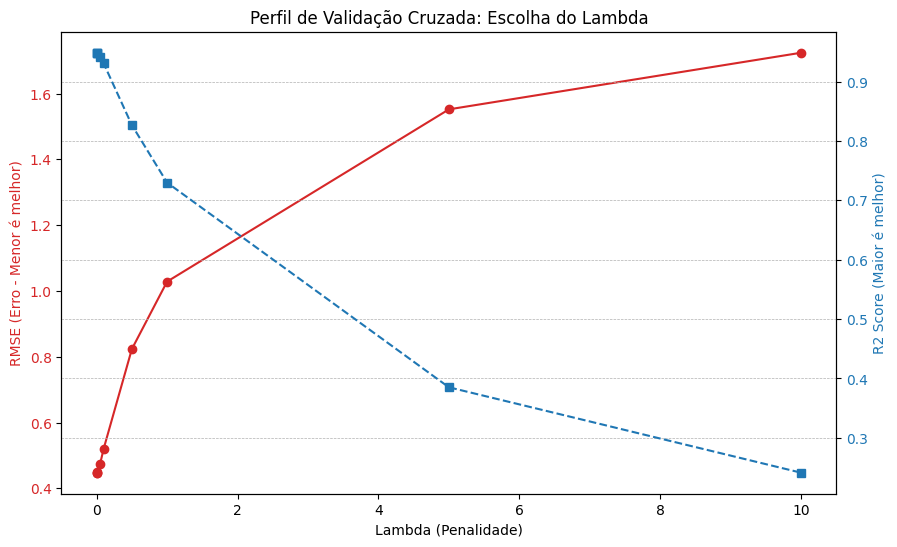

Melhor Lambda encontrado: 0


In [20]:
# AJUSTE FINO: Focar a busca entre 0 e 1, com passos bem pequenos
lambdas_search = [0, 0.001, 0.01, 0.05, 0.1, 0.5, 1.0, 5.0, 10.0]

# 2. Rodar CV
rmse_scores, r2_scores = k_fold_cv_scratch(X_train, y_train, lambdas_search, k=5)

# 3. Reportar Processo (Gráficos)
fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:red'
ax1.set_xlabel('Lambda (Penalidade)')
ax1.set_ylabel('RMSE (Erro - Menor é melhor)', color=color)
ax1.plot(lambdas_search, rmse_scores, marker='o', color=color, label='RMSE')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # Segundo eixo y para o R2
color = 'tab:blue'
ax2.set_ylabel('R2 Score (Maior é melhor)', color=color)
ax2.plot(lambdas_search, r2_scores, marker='s', linestyle='--', color=color, label='R2')
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Perfil de Validação Cruzada: Escolha do Lambda')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

# 4. Selecionar Melhor Lambda (Baseado no menor RMSE)
best_lambda_idx = np.argmin(rmse_scores)
best_lambda = lambdas_search[best_lambda_idx]
print(f"Melhor Lambda encontrado: {best_lambda}")

# Treinamento Final e Comparação (Scratch vs Scikit-Learn)

Agora usamos o $\lambda$ ótimo encontrado para treinar o modelo final em todo o conjunto de treino e avaliá-lo no conjunto de teste. Também comparamos nossos resultados com a implementação oficial do sklearn.linear_model.Ridge.Nota sobre a comparação: Como nossos dados (X_train) já possuem a coluna de viés (1s) adicionada manualmente, devemos configurar o Scikit-Learn com fit_intercept=False para que ele não adicione uma segunda coluna de intercepto, garantindo uma comparação justa.

RESULTADOS FINAIS NO CONJUNTO DE TESTE (Lambda=0)
Métrica    | Scratch         | Scikit-Learn   
----------------------------------------------
RMSE       | 0.41947         | 0.41883
R2           | 0.95575         | 0.95589
----------------------------------------------


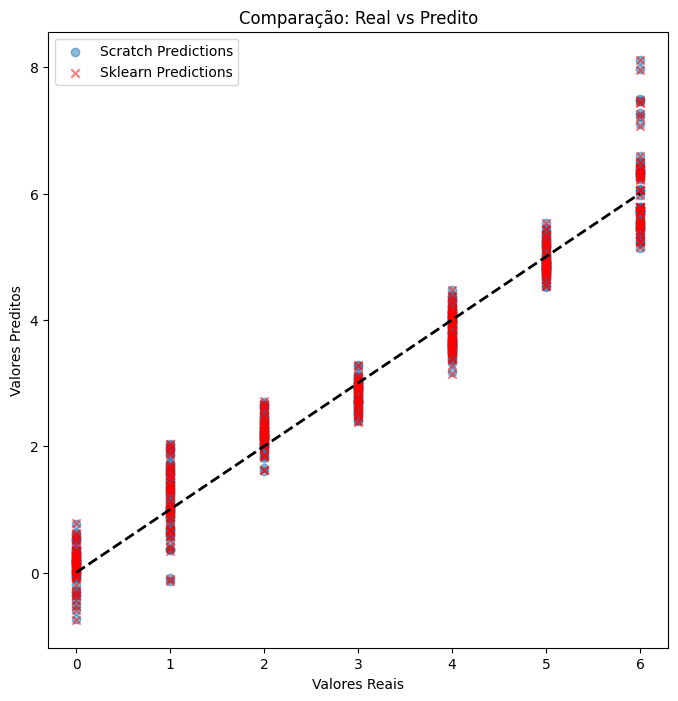

In [21]:
from sklearn.linear_model import Ridge

# --- IMPLEMENTAÇÃO DO ZERO (SCRATCH) ---
final_model_scratch = RidgeRegressionScratch(learning_rate=0.01, n_iterations=5000, lambda_val=best_lambda)
final_model_scratch.fit(X_train, y_train)
y_pred_scratch = final_model_scratch.predict(X_test)

rmse_scratch = np.sqrt(mean_squared_error(y_test, y_pred_scratch))
r2_scratch = r2_score(y_test, y_pred_scratch)

# --- IMPLEMENTAÇÃO BUILT-IN (SCIKIT-LEARN) ---
# fit_intercept=False pois X_train já tem a coluna de 1s (bias)
sklearn_model = Ridge(alpha=best_lambda, fit_intercept=False)
sklearn_model.fit(X_train, y_train)
y_pred_sklearn = sklearn_model.predict(X_test)

rmse_sk = np.sqrt(mean_squared_error(y_test, y_pred_sklearn))
r2_sk = r2_score(y_test, y_pred_sklearn)

# --- RELATÓRIO FINAL ---
print("="*50)
print(f"RESULTADOS FINAIS NO CONJUNTO DE TESTE (Lambda={best_lambda})")
print("="*50)
print(f"{'Métrica':<10} | {'Scratch':<15} | {'Scikit-Learn':<15}")
print("-" * 46)
print(f"{'RMSE':<10} | {rmse_scratch:.5f}         | {rmse_sk:.5f}")
print(f"{'R2':<10}   | {r2_scratch:.5f}         | {r2_sk:.5f}")
print("-" * 46)

# Verificação visual
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred_scratch, alpha=0.5, label='Scratch Predictions')
plt.scatter(y_test, y_pred_sklearn, alpha=0.5, marker='x', color='red', label='Sklearn Predictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Valores Reais')
plt.ylabel('Valores Preditos')
plt.title('Comparação: Real vs Predito')
plt.legend()
plt.show()